In [139]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from numpy import ma

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation

from scipy.ndimage import measurements
from scipy import signal
from scipy import ndimage as ndi

## I/O

In [140]:
img_raw = io.imread('02.tif')
print(img_raw.shape)

(15, 728, 968, 3)


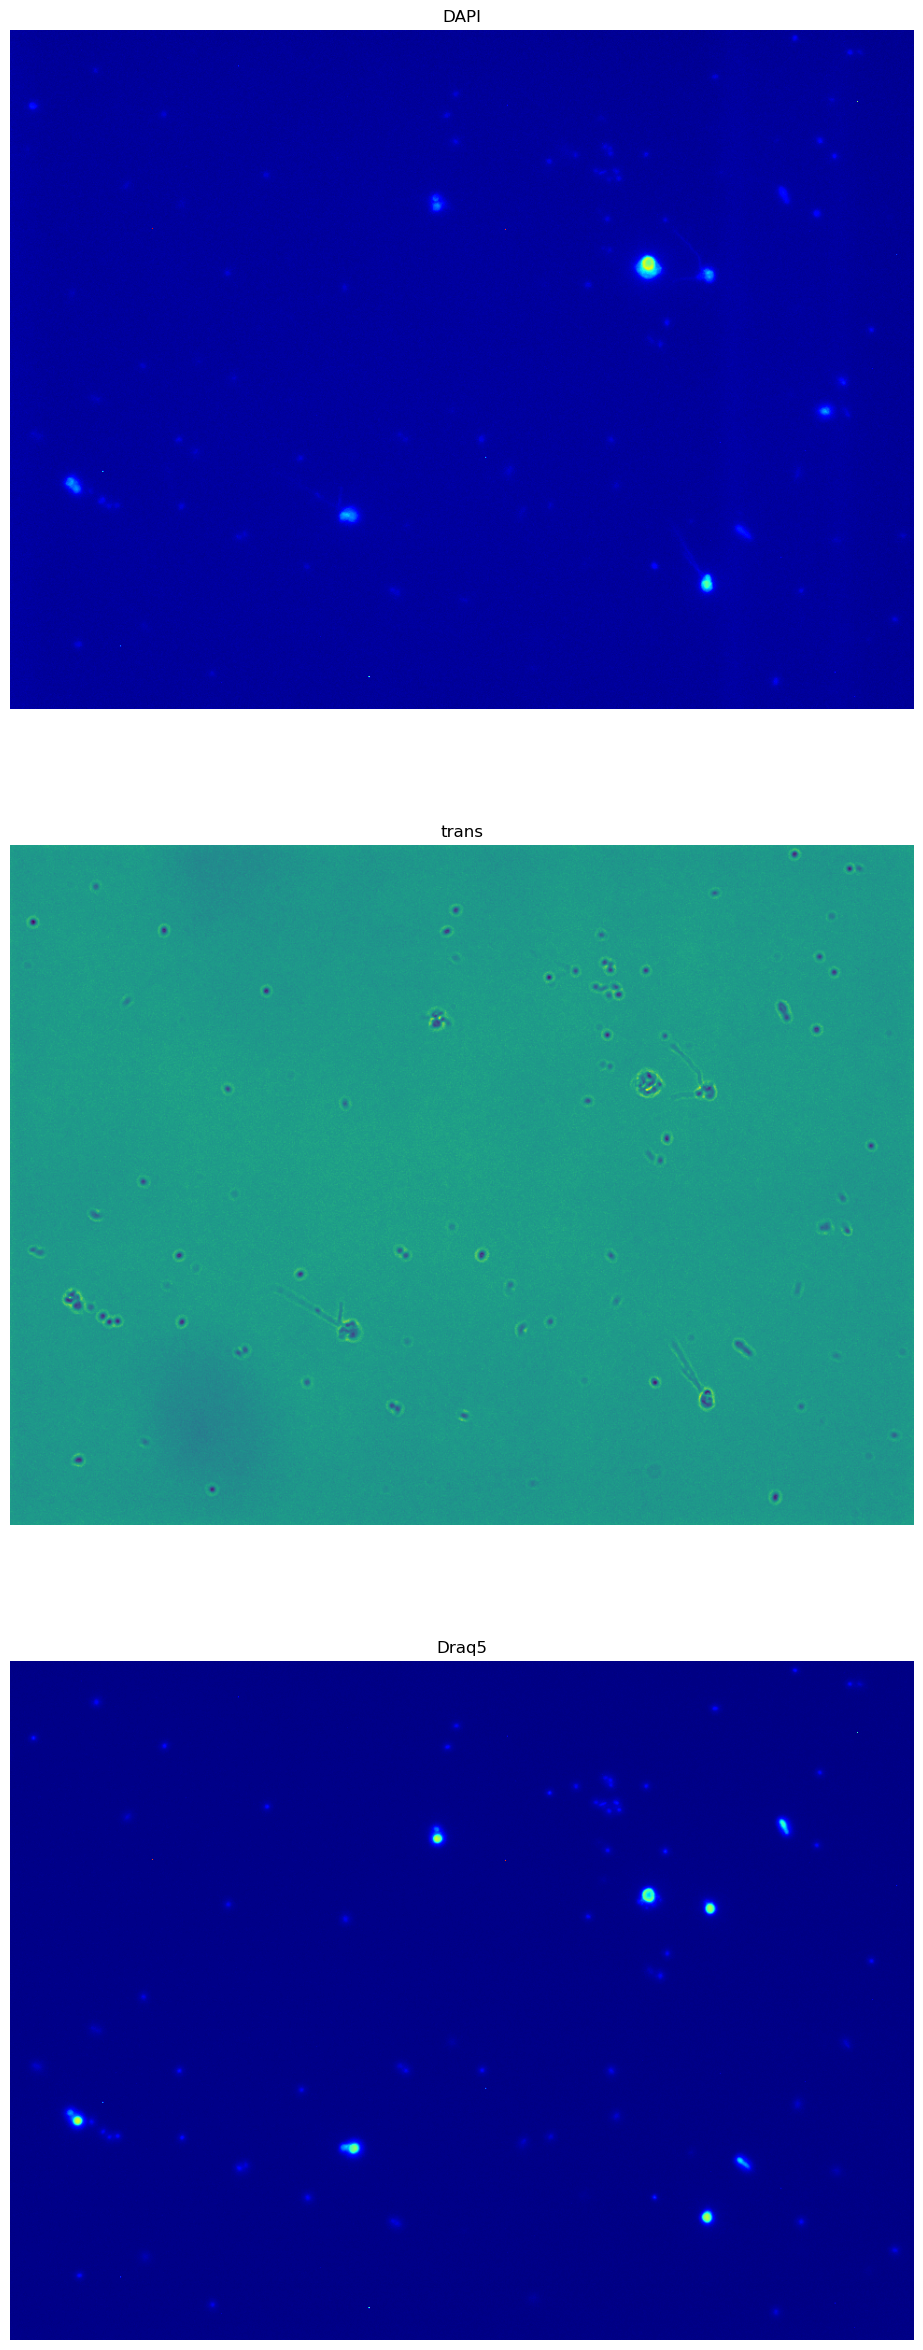

In [141]:
img_ch0 = np.max(img_raw[6:10,:,:,0], axis=0)  # DAPI
img_ch1 = np.max(img_raw[6:10,:,:,1], axis=0)  # trans
img_ch2 = np.max(img_raw[6:10,:,:,2], axis=0)  # Draq5



plt.figure(figsize=(30,30))

ax0 = plt.subplot(311)
ax0.imshow(img_ch0, cmap='jet')
ax0.set_title('DAPI')
ax0.axis('off')

ax1 = plt.subplot(312)
ax1.imshow(img_ch1)
ax1.set_title('trans')
ax1.axis('off')

ax2 = plt.subplot(313)
ax2.imshow(img_ch2, cmap='jet')
ax2.set_title('Draq5')
ax2.axis('off')

plt.show()

## Cell mask

#### Raw mask creation

/tmp/ipykernel_3604/251777848.py:4: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  img_ch1_filt = filters.rank.gradient(img_ch1_filt, morphology.disk(3))


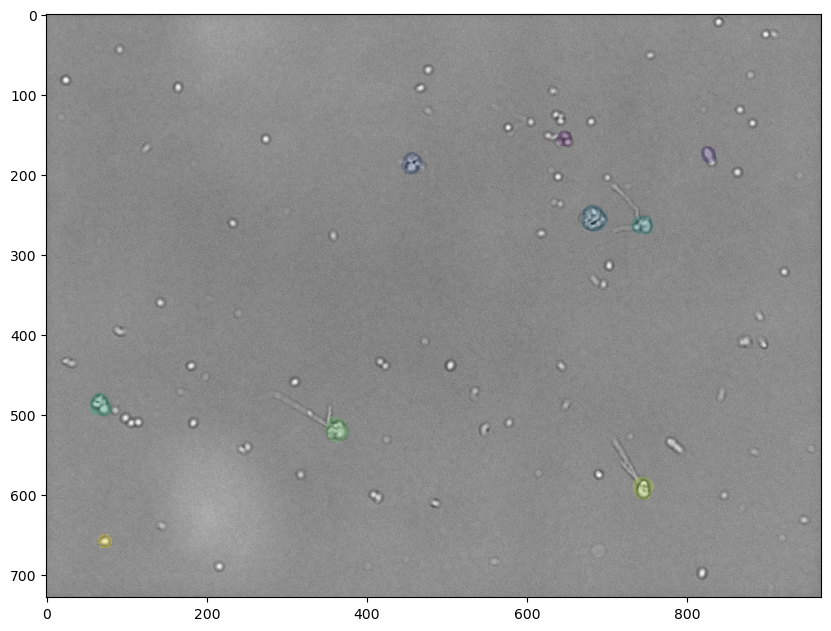

In [142]:
img_ch1_filt = filters.gaussian(img_ch1, sigma=2)

img_ch1_filt = img_ch1_filt / np.max(np.abs(img_ch1_filt))
img_ch1_filt = filters.rank.gradient(img_ch1_filt, morphology.disk(3))

mask = img_ch1_filt > filters.threshold_otsu(img_ch1_filt)
mask = ndi.binary_fill_holes(mask)
mask = segmentation.clear_border(mask)

mask = morphology.erosion(mask, footprint=morphology.disk(7))
mask = morphology.dilation(mask, footprint=morphology.disk(10))

labels, labels_num = ndi.label(mask)


plt.figure(figsize=(10,10))
plt.imshow(img_ch1, cmap='Greys')
plt.imshow(ma.masked_where(~mask, labels), alpha=.3)

#### Mask filtering

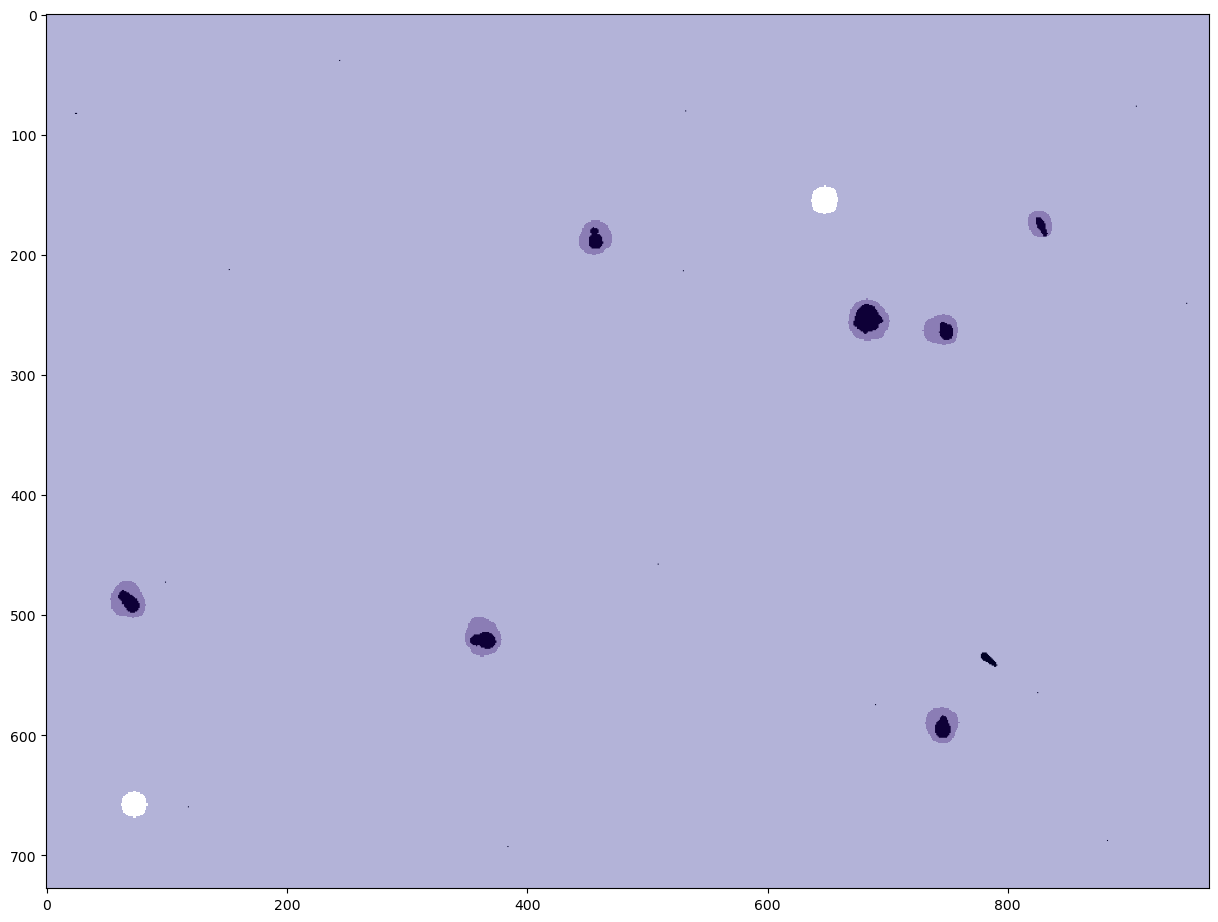

In [143]:
ctrl_fluo_img = img_ch0 + img_ch2
ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
connected = sums > 0
debris_mask = connected[labels]

fin_mask = np.copy(mask)
fin_mask[~debris_mask] = 0

cells_labels, cells_num = ndi.label(fin_mask)

plt.figure(figsize=(15,15))
plt.imshow(ctrl_fluo_mask, cmap='Greys')
plt.imshow(ma.masked_where(~fin_mask, fin_mask), alpha=.3)
plt.imshow(ma.masked_where(~debris_mask, debris_mask), cmap='jet', alpha=.3)

#### Cells separation

In [144]:
class OneCell():
    def __init__(self, dapi_img, draq_img, trans_img, cell_mask):
        self.dapi_img = dapi_img
        self.draq_img = draq_img
        self.trans_img = trans_img
        self.cell_mask = cell_mask

        self.dapi_norm = (self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        self.draq_norm = (self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        zeros = np.zeros_like(self.dapi_norm)

        self.rgb_overlay = np.stack([self.dapi_norm, self.draq_norm, zeros], axis=-1)  # red - DAPI, green - Draq5


    def show_imgs(self):
        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(221)
        ax0.imshow(self.trans_img, cmap='Greys')
        ax0.imshow(ma.masked_where(~self.cell_mask, self.cell_mask), cmap='jet', alpha=.3)
        ax0.set_title('Trans ch. with cell mask overlay')
        ax0.axis('off')

        ax1 = plt.subplot(222)
        ax1.imshow(self.rgb_overlay)
        ax1.set_title('DAPI-red, Draq5-green')
        ax1.axis('off')

        plt.show()

    
    def create_kineto_mask(self):
        diff = self.dapi_norm - self.draq_norm

        self.k_mask_raw = diff > filters.threshold_otsu(diff)

        diff_masked = ma.masked_where(~self.k_mask_raw, diff)

        self.k_mask = diff > filters.threshold_otsu(diff_masked.compressed())

        self.n_mask = self.draq_norm > filters.threshold_otsu(self.draq_norm)

        # thresholds = filters.threshold_multiotsu(diff)
        # self.k_regions = np.digitize(diff, bins=thresholds)

        if np.sum(self.k_mask) > np.size(diff) * 0.5:
            print("Bad mask")

        self.kn_label = np.zeros_like(self.dapi_img)
        self.kn_label[self.k_mask] = 1
        self.kn_label[self.n_mask] = 2

        # self.kn_mask = np.copy(self.kn_label)
        self.kn_mask = self.kn_label != 0

        plt.figure(figsize=(10, 10))
        plt.imshow(self.trans_img, cmap='Greys')
        # plt.imshow(self.k_regions, cmap='bwr', alpha=.3)
        plt.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        plt.title('Red-nucleus')
        plt.axis('off')

        plt.show()


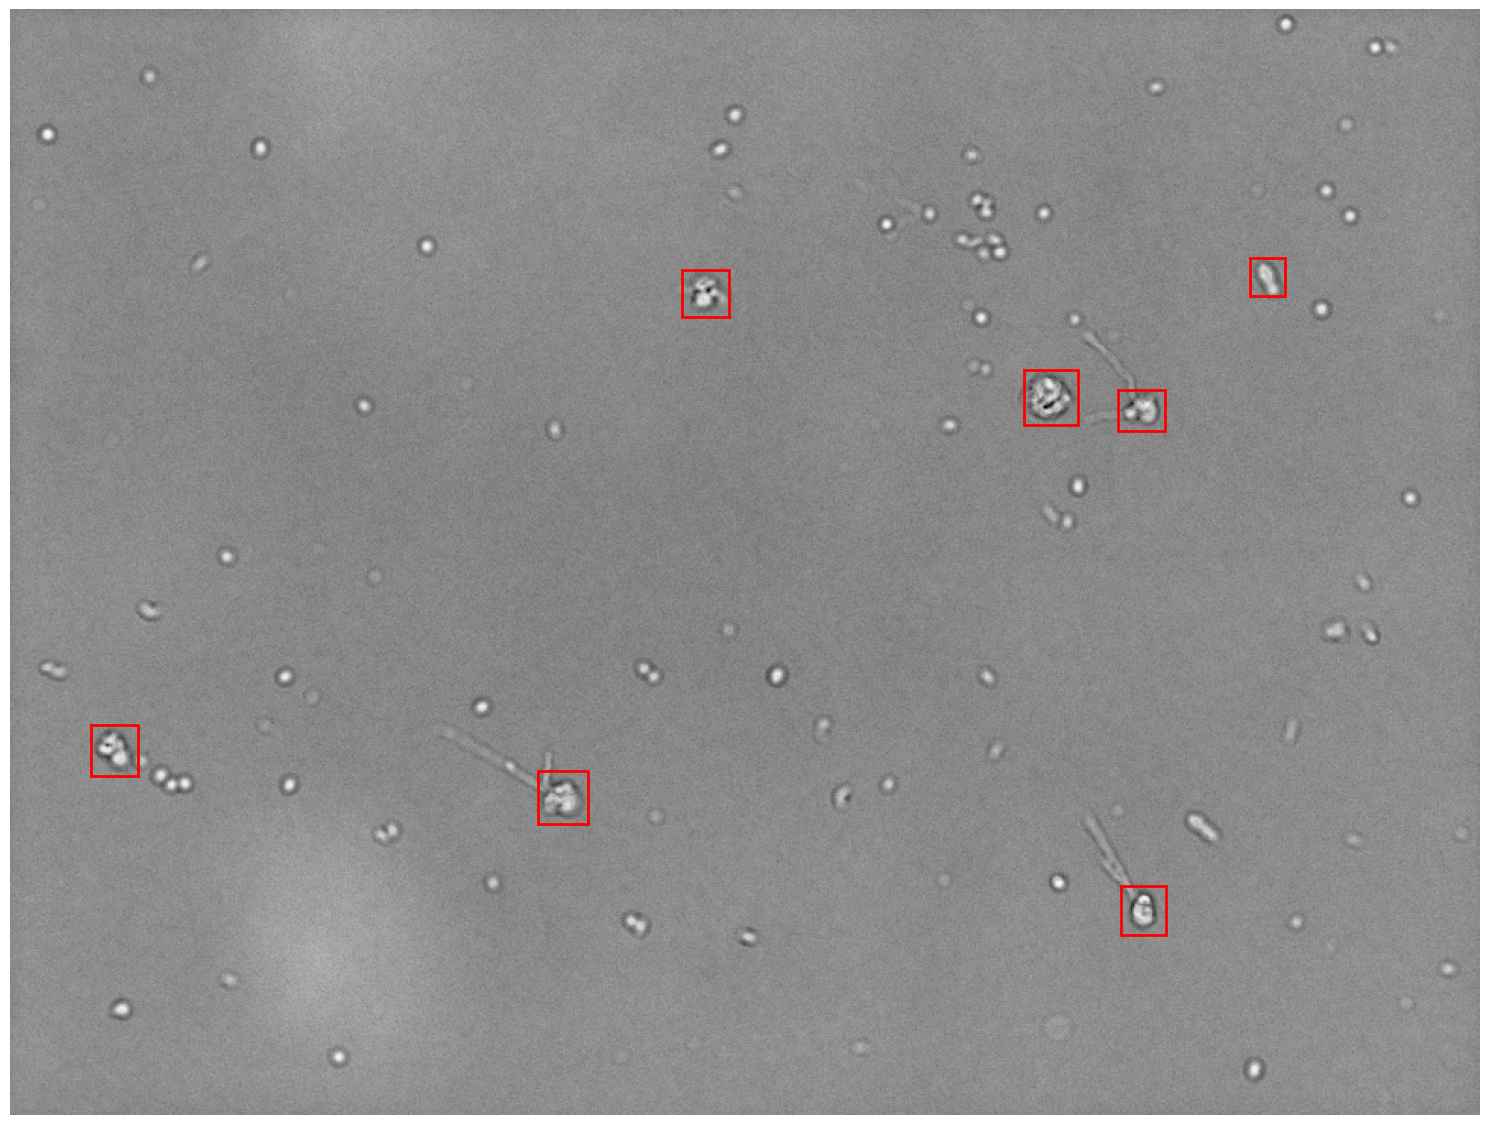

In [145]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_ch1, cmap='Greys')

cells_list = []
for region in measure.regionprops(cells_labels):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

    cells_list.append(OneCell(dapi_img=img_ch0[minr:maxr, minc:maxc],
                              draq_img=img_ch2[minr:maxr, minc:maxc],
                              trans_img=img_ch1[minr:maxr, minc:maxc],
                              cell_mask=fin_mask[minr:maxr, minc:maxc]))

ax.set_axis_off()
plt.tight_layout()
plt.show()

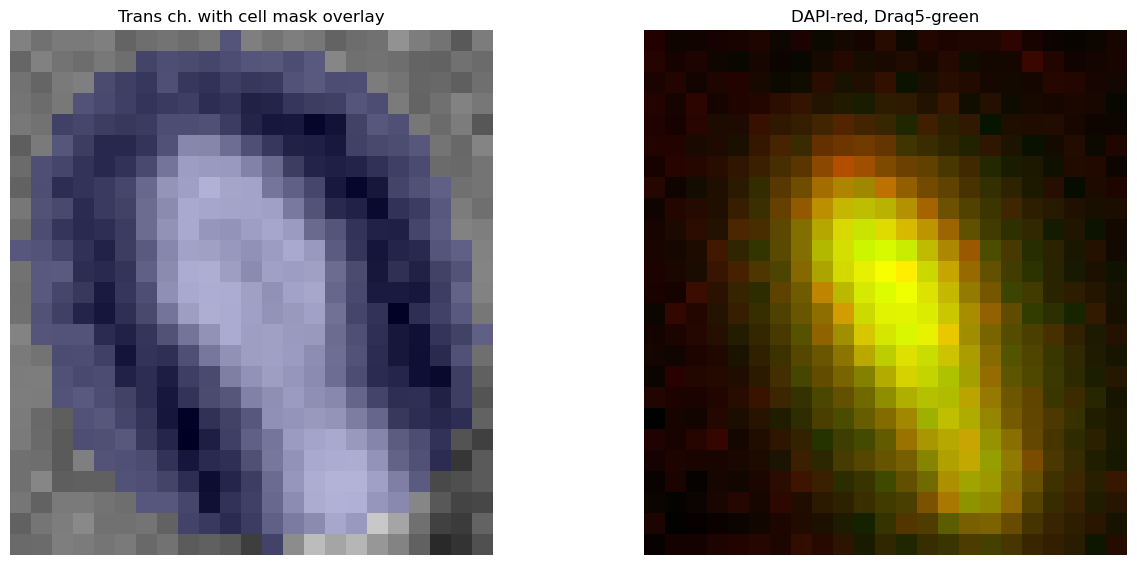

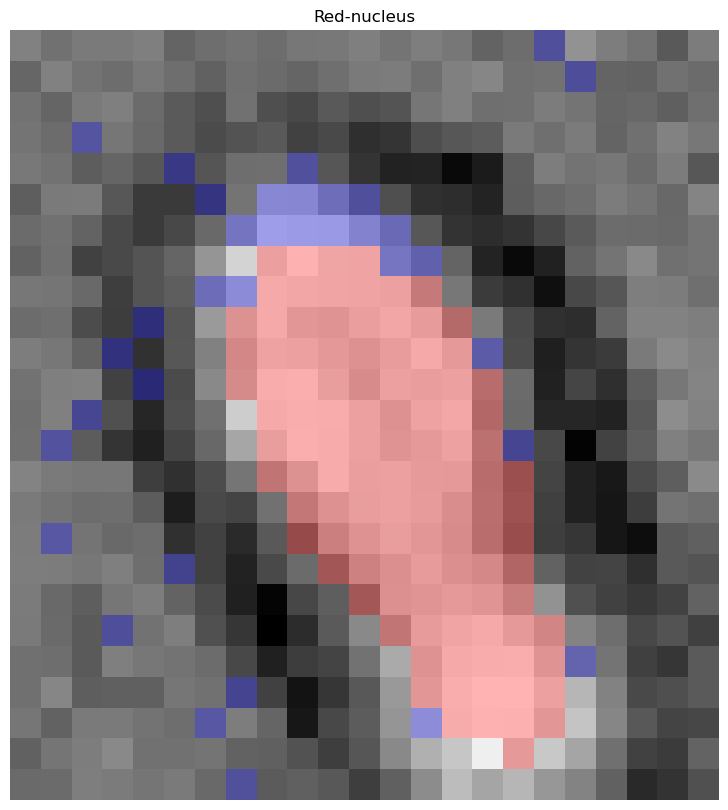

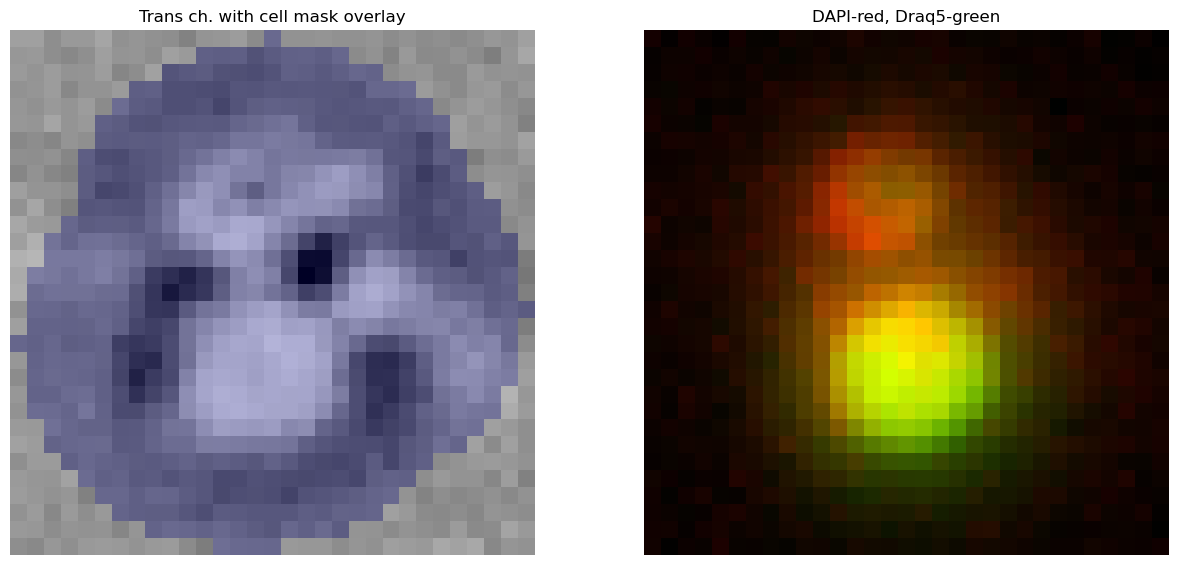

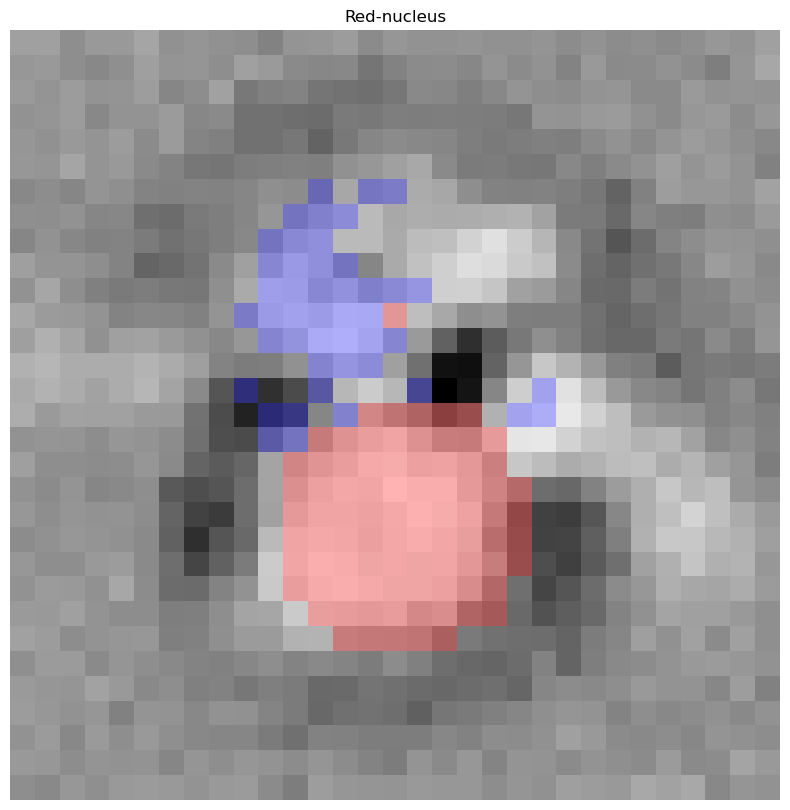

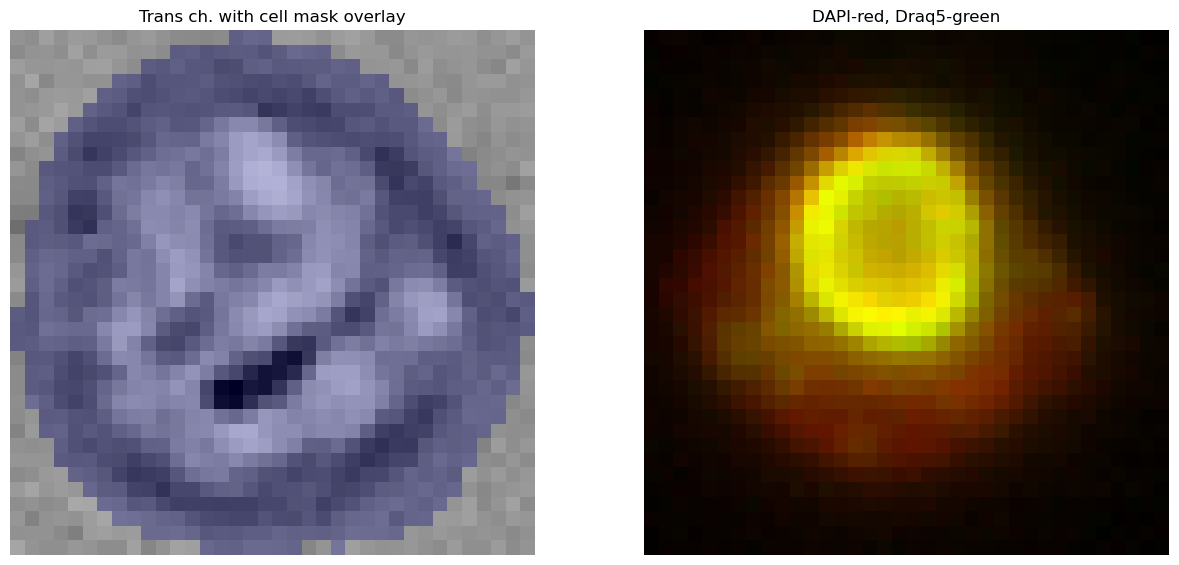

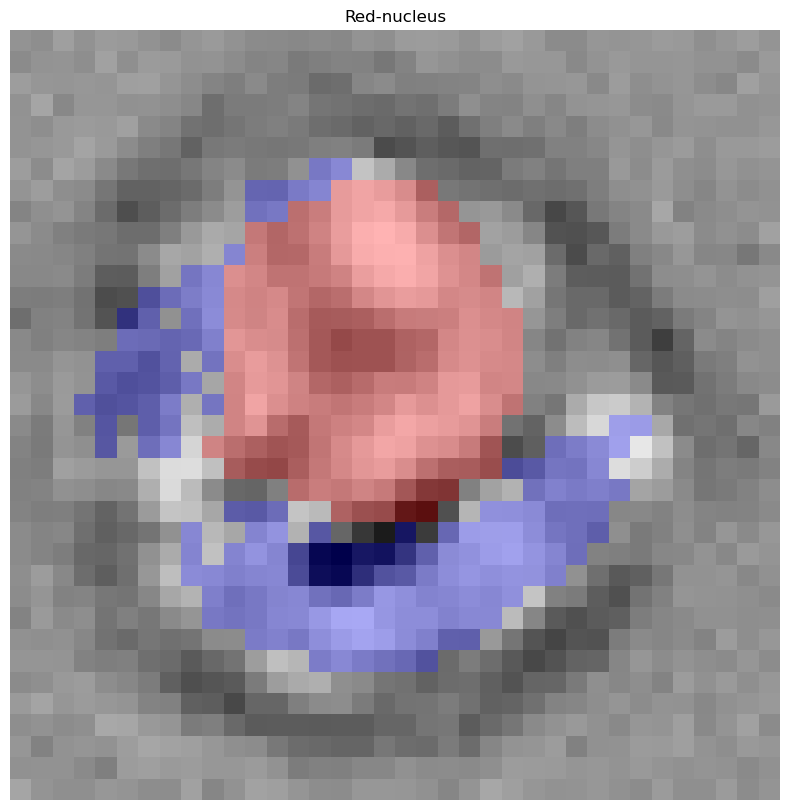

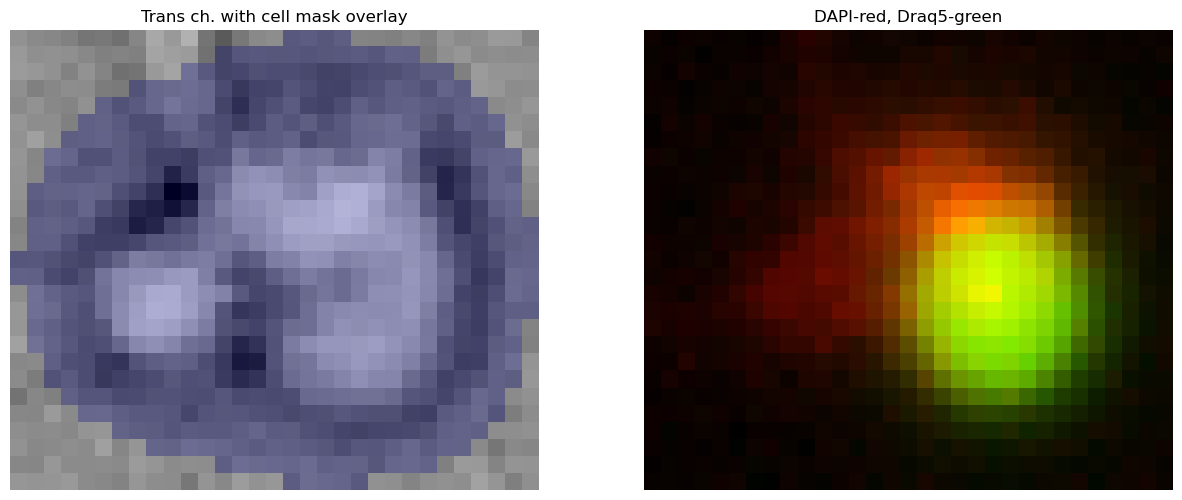

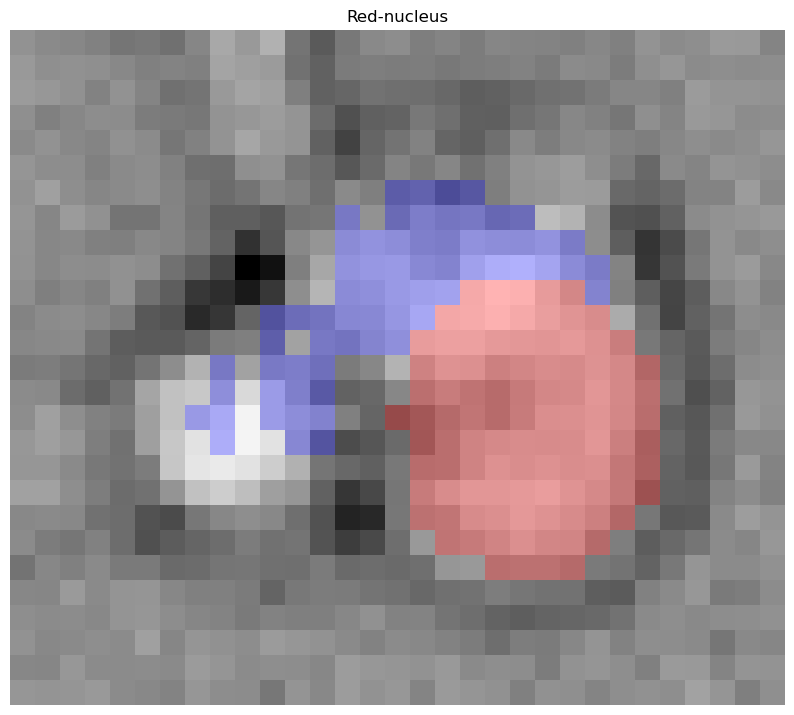

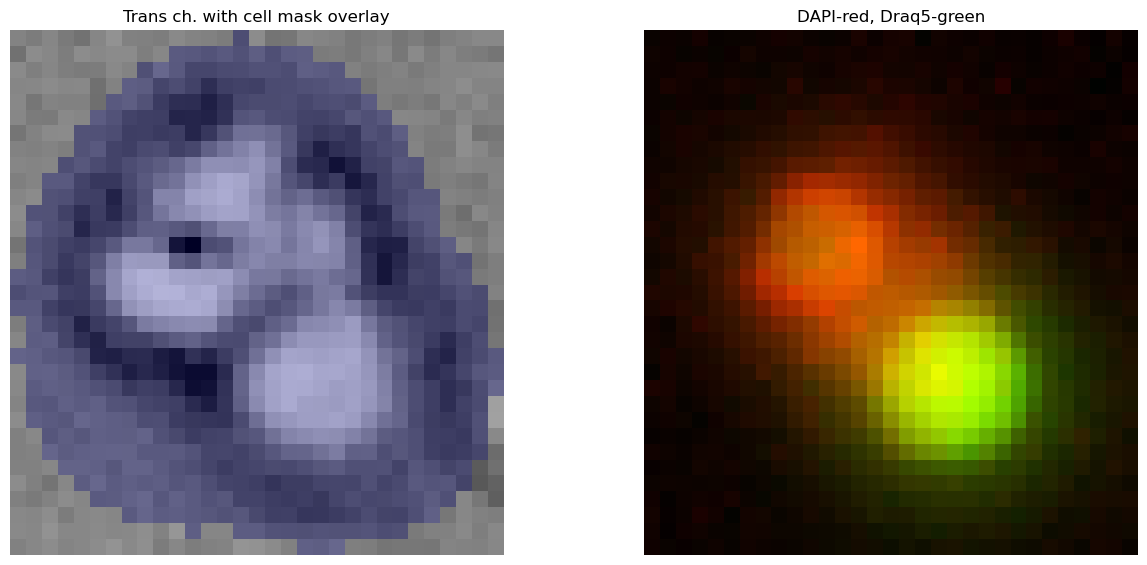

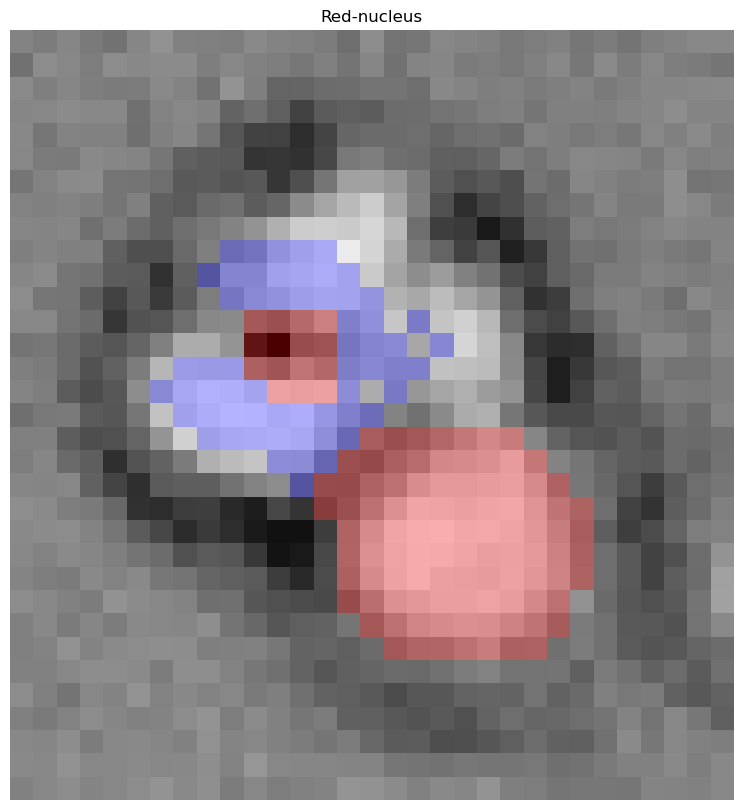

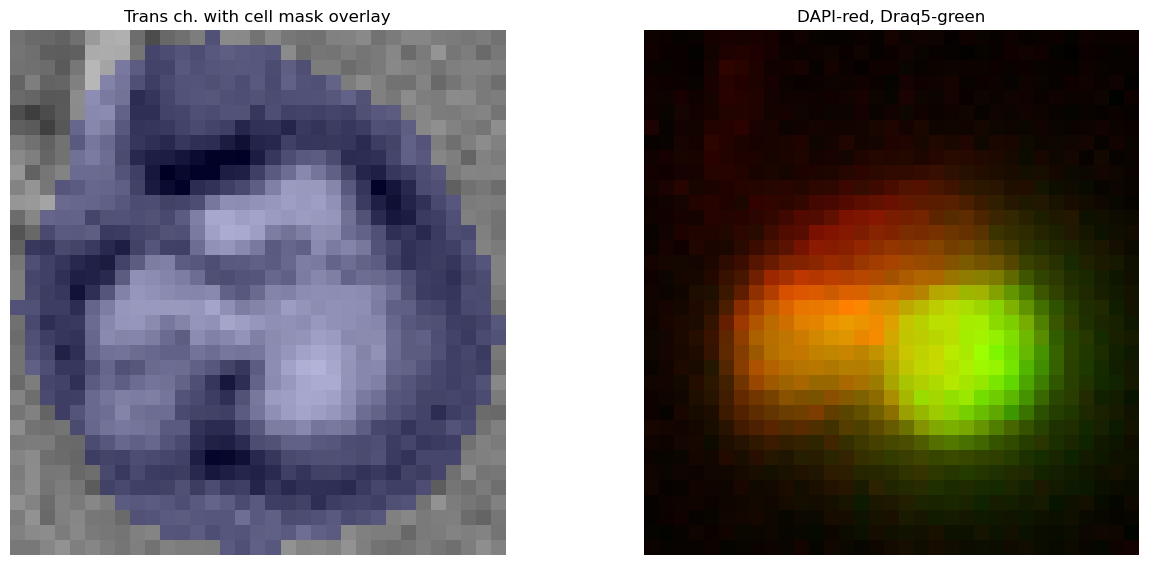

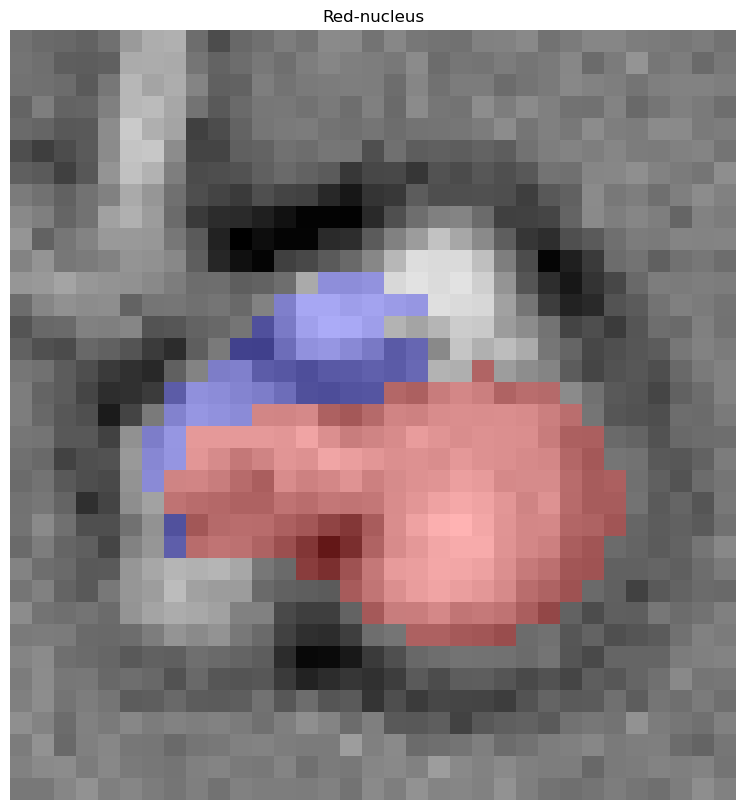

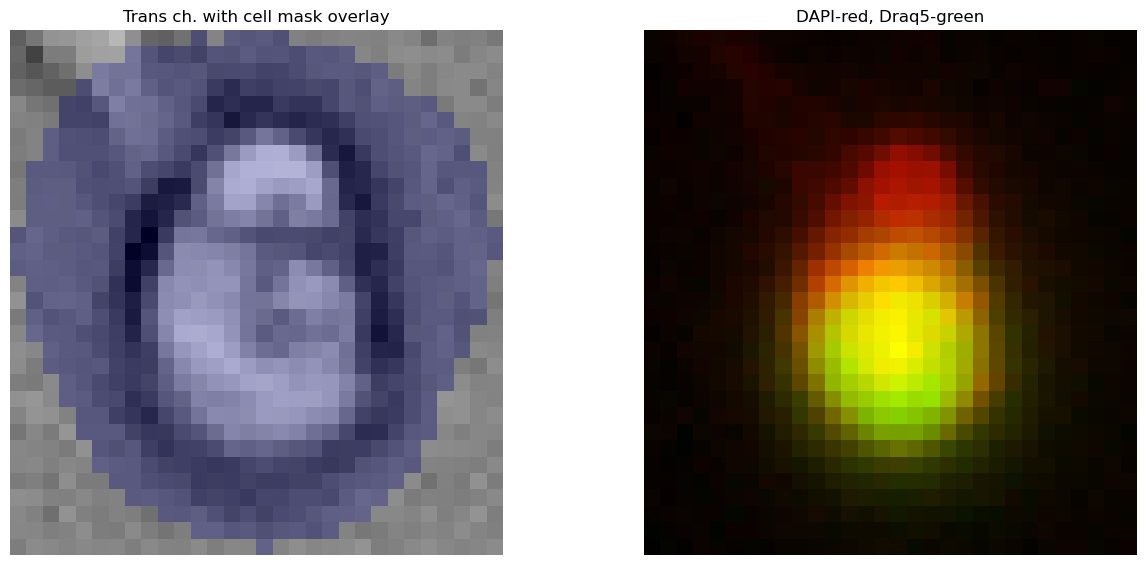

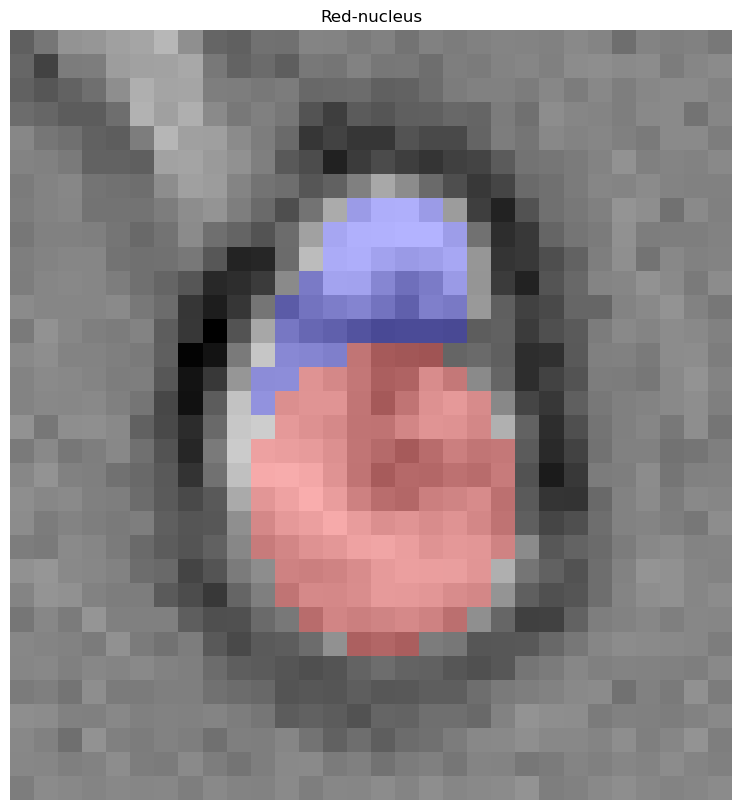

In [146]:
for cell in cells_list:
    cell.show_imgs()
    cell.create_kineto_mask()
